### Metric Learning

Celem zadania jest obserwacja jak zmiana wykorzystywanej przez klasyfikator k-NN metryki wpływa na kształt granicy decyzyjnej, a więc w efekcie na jego skuteczność.

In [35]:
!pip install webcolors

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import webcolors
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier  
from matplotlib.colors import ListedColormap
from pandas.core.frame import DataFrame
from typing import Dict, Tuple

In [0]:
colors_dict = {
  '#ffffff': ('white', 0),
  '#ff0000': ('red', 1),
  '#ffbf00': ('orange', 2),
  '#ffff00': ('yellow', 3),
  '#00ff00': ('green', 4),
  '#00bfff': ('blue', 5),
  '#0000ff': ('dark blue', 6),
  '#551a8b': ('purple', 7),
  '#ffb6c1': ('pink', 8),
  '#000000': ('black', 9)
}

def closest_colour(requested_colour):
  min_colours = {}
  for key, name in colors_dict.items():
      r_c, g_c, b_c = webcolors.hex_to_rgb(key)
      rd = (r_c - requested_colour[0]) ** 2
      gd = (g_c - requested_colour[1]) ** 2
      bd = (b_c - requested_colour[2]) ** 2
      min_colours[(rd + gd + bd)] = name
  return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
  try:
      closest_name = webcolors.rgb_to_name(requested_colour)
  except ValueError:
      closest_name = closest_colour(requested_colour)
  return closest_name


In [0]:
def noise(point: float):
  return point + random.gauss(0, 1)

def write_data_to_csv(source_img: str, dest_path: str):
  """
  Save given image to csv-like format.
  Csv file contains 4 columns: x co-ordinate, y co-ordinate, color number, color name
  """
  image = Image.open(source_img)
  width, height = image.size
  with open(dest_path, 'w') as dest_file:
      for x in range(0, width):
          for y in range(0, height):
              color, color_num = closest_colour(image.getpixel((x,y)))
              if color != 'white':
                  dest_file.write(f'{noise(x)};{noise(y)};{color_num};{color}\n')

### Dane

Do wygenerowania danych posluzylem sie Paint'em. Nastepnie dane zrzucilem do csv z uzyciem pandasa, aby latwo ponownie ich uzyc. Do kazdego punktu dodalem delikatn noise (random.gauss(0,1)).

Dane normalizowalem do 10 podstawowych kolorow z pomoca biblioteki webcolors.

In [0]:
data = ('data7.png', 'data8.png', 'data9.png')
output_paths = ('labeled-dataset1.csv', 'labeled-dataset2.csv','labeled-dataset3.csv')

In [0]:
%matplotlib inline
def show_data(img_path):
  pil_im = Image.open(img_path, 'r')
  plt.imshow(np.asarray(pil_im))

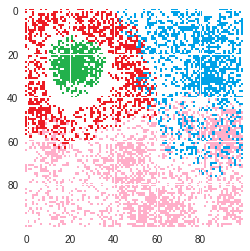

In [41]:
show_data(data[0])

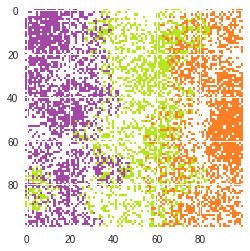

In [42]:
show_data(data[1])

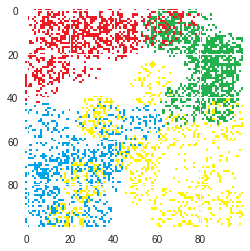

In [43]:
show_data(data[2])

In [0]:
# Save all images(data) to file(csv)
for _in, _out in zip(data, output_dataset):
  write_data_to_csv(_in, _out)

In [0]:
def divide_dataset(shuffled_dataset: DataFrame) -> Tuple[np.ndarray]:
  """
  Return 4-elements tuple with X_train, y_train, X_test, y_test
  Function cast input - pandas DataFrame to  to numpy array, just for calucaltion simiplicity
  """
  if shuffled_dataset.shape[1] != 3:
    raise ValueError("Shuffled dataset must contains x,y and numeric value columns")
    
  shuffled_dataset = np.array(shuffled_dataset)
  train_size = int(0.7 * shuffled_dataset.shape[0])
  train, test = shuffled_dataset[:train_size, :], shuffled_dataset[train_size:, :]
  
  return train[:, 0:2], train[:, 2], test[:, 0:2], test[:, 2]


In [0]:
def train(X_train: np.ndarray, 
          y_train: np.ndarray,
          k: int, 
          weights: str = 'uniform',
          metric: str = 'euclidean',
          **kwargs) -> KNeighborsClassifier:
  
  clf = KNeighborsClassifier(k, weights=weights, metric=metric, **kwargs)
  clf.fit(X_train, y_train)
  return clf


def predict(knn_classifier: KNeighborsClassifier, 
            X_train: np.ndarray, 
            y_train: np.ndarray,
            X_test: np.ndarray, 
            y_test: np.ndarray,
            h: float = 0.1) -> tuple:
  
  x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
  y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
  
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))
  
  P_train = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  P_train = P_train.reshape(xx.shape)
  
  accuracy = clf.score(X_test, y_test)
  
  return xx, yy, P_train, accuracy

def plot_decision_boundry(xx, 
                          yy, 
                          P_train,
                          X_test, 
                          y_test, 
                          cmap_light,
                          cmap_bold) -> None:
  plt.figure()
  plt.pcolormesh(xx, yy, P_train, cmap=cmap_light)
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, edgecolor='k', s=20)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  

In [0]:
cmap_light = ListedColormap(['#D7BDE2','#F9E79F', '#AED6F1', '#E6B0AA', '#A2D9CE', '#D5DBDB'])
cmap_bold = ListedColormap([ '#9B59B6','#F1C40F', '#5DADE2', '#C0392B', '#16A085', '#95A5A6'])

In [0]:
def load_datasets(dataset_paths: list):
  for path in dataset_paths:
    dataset_df = pd.read_csv(path, sep=';', names=['x', 'y', 'color_name', 'color_num'])
    dataset_df = dataset_df.sample(frac=1).iloc[:, :3]
    yield dataset_df

### Trening, testowanie, wizualizacja

Do trenowania danych posluzylem sie juz gotowym algorytmem knn z biblioteki scikit learn.
Opieralem sie na przykladach z dokumentacji.

### kNN with k=1, uniform weights and Euclidean metric

Accuracy:  0.8892380204241949


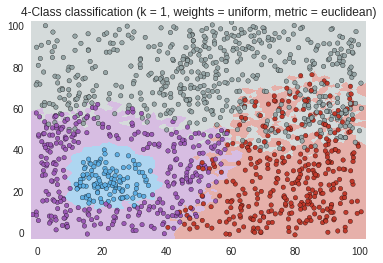

Accuracy:  0.8272425249169435


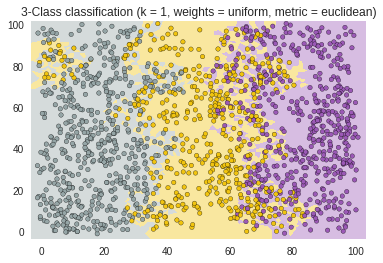

Accuracy:  0.8565169769989047


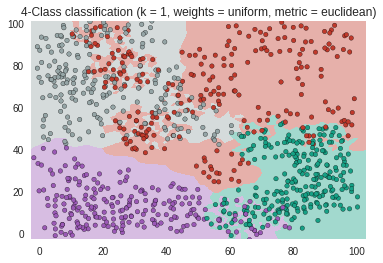

In [90]:
k = 1
weights = 'uniform'
metric = 'euclidean'


for dataset in load_datasets(output_paths):
  X_train, y_train, X_test, y_test = divide_dataset(dataset)

  clf = train(X_train, y_train, k, weights=weights)
  xx, yy, P_train, accuracy = predict(clf, X_train, y_train, X_test, y_test)
  print("Accuracy: ", accuracy)


  plot_decision_boundry(xx, yy, P_train, X_test, y_test, cmap_light, cmap_bold)

  plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(len(np.unique(y_train)), k, weights, metric))
  plt.show()

### kNN with k=3, uniform weights and Euclidean metric

Accuracy:  0.8837391987431265


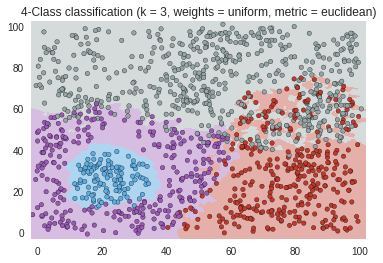

Accuracy:  0.837873754152824


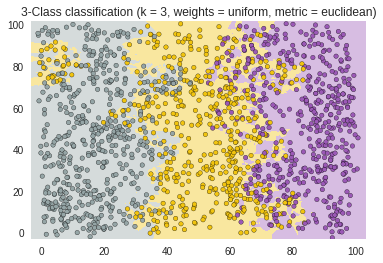

Accuracy:  0.8773274917853231


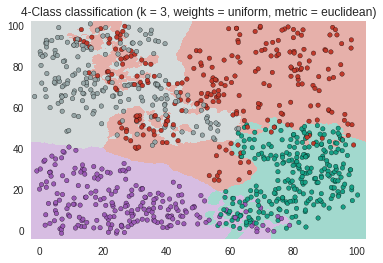

In [91]:
k = 3
weights = 'uniform'
metric = 'euclidean'

for dataset in load_datasets(output_paths):
  X_train, y_train, X_test, y_test = divide_dataset(dataset)

  clf = train(X_train, y_train, k, weights=weights)
  xx, yy, P_train, accuracy = predict(clf, X_train, y_train, X_test, y_test)
  print("Accuracy: ", accuracy)

  plot = plot_decision_boundry(xx, yy, P_train, X_test, y_test, cmap_light, cmap_bold)

  plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(len(np.unique(y_train)), k, weights, metric))
  plt.show()

### kNN with k=1, distance weights and Euclidean metric

Accuracy:  0.8915946582875098


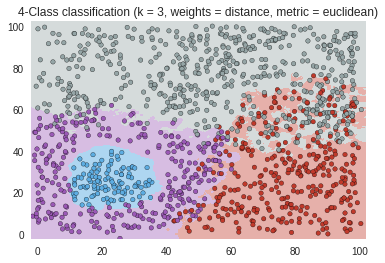

Accuracy:  0.8365448504983388


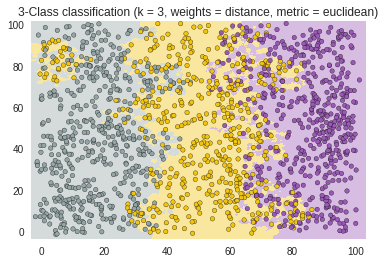

Accuracy:  0.8543263964950711


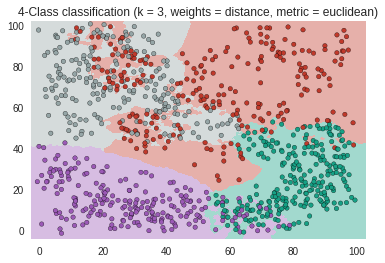

In [92]:
k = 3
weights = 'distance'
metric = 'euclidean'

for dataset in load_datasets(output_paths):
  X_train, y_train, X_test, y_test = divide_dataset(dataset)

  clf = train(X_train, y_train, k, weights=weights)
  xx, yy, P_train, accuracy = predict(clf, X_train, y_train, X_test, y_test)
  print("Accuracy: ", accuracy)

  plot = plot_decision_boundry(xx, yy, P_train, X_test, y_test, cmap_light, cmap_bold)

  plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(len(np.unique(y_train)), k, weights, metric))
  plt.show()

### kNN with k=1, uniform weights and Mahalanobis metric

Accuracy:  0.9025923016496465


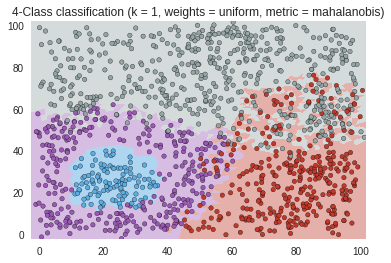

Accuracy:  0.8358803986710963


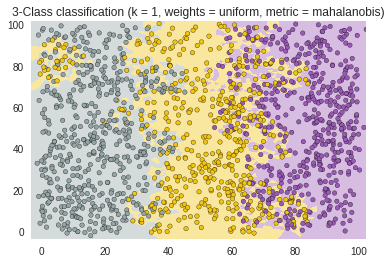

Accuracy:  0.859802847754655


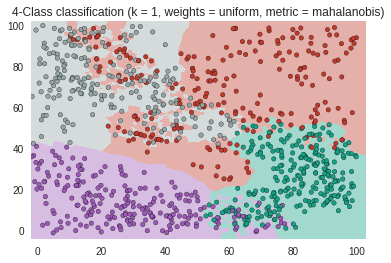

In [93]:
k = 1
weights = 'uniform'
metric = 'mahalanobis'

for dataset in load_datasets(output_paths):
  X_train, y_train, X_test, y_test = divide_dataset(dataset)

  clf = train(X_train, y_train, k, weights=weights, metric=metric, metric_params={'VI': np.linalg.pinv(np.cov(X_train ,rowvar=False))})
  xx, yy, P_train, accuracy = predict(clf, X_train, y_train, X_test, y_test)
  print("Accuracy: ", accuracy)

  plot = plot_decision_boundry(xx, yy, P_train, X_test, y_test, cmap_light, cmap_bold)

  plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(len(np.unique(y_train)), k, weights, metric))
  plt.show()

### kNN with k=1, uniform weights and Mahalanobis metric depending on region

Aby zrealizować ostatni punkt wykonaj następujące kroki:

* podziel obszar w którym leży zbiór na kilka podobszarów (np. 5x5);
* dla każdego z podobszarów wyznacz macierz kowariancji (używaną przez metrykę Mahalanobisa) tylko w oparciu o obserwacje leżące w tym podobszarze i podobszarach do niego przyległych;
* w zależności od klasyfikowanego regionu korzystaj z macierzy jemu właściwej.


In [0]:
def slice_dataset(X: np.ndarray, y: np.ndarray, slices: int, data_size: Tuple[int, int]) -> Dict[Tuple[int, int], Tuple[np.ndarray, np.ndarray]]:
    d0 = data_size[0] // slices
    d1 = data_size[1] // slices
    
    result = {}
    for s1 in range(slices):
        s1_low = s1 * d0
        s1_high = (s1 + 1) * d0
        for s2 in range(slices):
            s2_low = s2 * d1
            s2_high = (s2 + 1) * d1
            condition = (
                (s1_low <= X[:, 0]) * 
                (X[:, 0] <= s1_high) *
                (s2_low <= X[:, 1]) * 
                (X[:, 1] <= s2_high)
            )
            result[(s1, s2)] = X[condition], y[condition]
    return result

Niestety dla ponizszego przykladu nie udalo mi sie stworzyc odpowiednich wykresow. Nie potrafilem polaczyc wielu malych plotow w jeden duzy. Zabraklo i wiedzy jak i czasu. Deadline :////

In [125]:
k = 1
weights = 'uniform'
metric = 'mahalanobis'
slices = 5

for num, dataset in enumerate(load_datasets(output_paths)):
  X_train, y_train, X_test, y_test = divide_dataset(dataset)
  sliced_train_data = slice_dataset(X_train, y_train, slices, (100,100))
  sliced_test_data = slice_dataset(X_test, y_test, slices, (100,100))

  accuracy = 0

  for s1 in range(slices):
    for s2 in range(slices):
      sl_train = sliced_train_data[(s1,s2)]
      sl_test = sliced_test_data[(s1, s2)]

      clf = train(sl_train[0], sl_train[1],
                  k, weights=weights, metric=metric,
                  metric_params={'VI': np.linalg.pinv(np.cov(sl_train[0] ,rowvar=False))})  

      xx, yy, P_train, acc = predict(clf, sl_train[0], sl_train[1], sl_test[0], sl_test[1])
      print(f"Accuracy for segement ({s1},{s2}): {acc}")
      accuracy += acc


  print(f"AVG ACCURACY FOR DATASET {num + 1}: {accuracy / slices ** 2}\n\n")
#   plot_decision_boundry(xx, yy, P_train, sl_test[0], sl_test[1], cmap_light, cmap_bold)
#   plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(3, k, weights, metric))
#   plt.show()

Accuracy for segement (0,0): 1.0
Accuracy for segement (0,1): 1.0
Accuracy for segement (0,2): 0.7291666666666666
Accuracy for segement (0,3): 0.8888888888888888
Accuracy for segement (0,4): 1.0
Accuracy for segement (1,0): 0.9821428571428571
Accuracy for segement (1,1): 1.0
Accuracy for segement (1,2): 0.8611111111111112
Accuracy for segement (1,3): 0.9666666666666667
Accuracy for segement (1,4): 1.0
Accuracy for segement (2,0): 0.7704918032786885
Accuracy for segement (2,1): 0.7692307692307693
Accuracy for segement (2,2): 0.7045454545454546
Accuracy for segement (2,3): 1.0
Accuracy for segement (2,4): 1.0
Accuracy for segement (3,0): 1.0
Accuracy for segement (3,1): 0.9183673469387755
Accuracy for segement (3,2): 0.5319148936170213
Accuracy for segement (3,3): 0.6764705882352942
Accuracy for segement (3,4): 1.0
Accuracy for segement (4,0): 1.0
Accuracy for segement (4,1): 1.0
Accuracy for segement (4,2): 0.5949367088607594
Accuracy for segement (4,3): 0.6379310344827587
Accuracy for 

### Wnioski:
* W przypadku moich datasetow knn z wiekszym parametrem k radzil sobie o wiele lepiej. Jest to z pewnoscia spowodowane gestoscia danych w obszarze a takze ich rozrzuceniem. Wg moich testow (prob i bledow) na moich danych testowych najabrdziej optymalne k jest w przedziale [7,10]. Zakladam, iz najlepiej byloby to sprawdzic wyrysowujac learning curves.

* Wybor pomiedzy glosowaniem wazonym i wiekszosciowe nie robilo wiekszego znaczenia dla moich danych. Dane byly zbyt gesto rozsiane i metryka wazona nie pokazala tutaj swojego potencjalu lub tez wad.

* KNN z metryka Mahalanobisa radzi sobie delikatnie lepiej niz ten z metryka Euklidesową. KNN z metryka Mahalanobisa jako jedyny przekroczyl 90% trafnosci na danych testowych.

* KNN z metryka Mahalanonbisa działajacy na mniejszych obszarach radzil sobie w wielu przypadkach idealnie, niektore predicty na danych testowych dawaly 100% trafnosc. Niestety czasami zdazaly sie tragiczne przypadki gdzie celnosc oscylowala w granicach 50%. W skutek czego srednia wszystkich wynikow, nie byla wcale lepsza niz w 4 przykladzie gdzie nie dzielilismy datasetu na mniejsze czesci. Obawiam sie, iz moze byc to winna samego datasetu jak mojej implementacji.